# NeedleNet and error correction for microneedle project
by [Yang Liu](https://liuyang12.github.io), [MIT CSAIL](https://csail.mit.edu). Last updated Sep 30, 2021 

## NeedleNet as the vision system

In [1]:
# import external packages
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from reedmuller import reedmuller  # Reed-Muller code

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# import internal packages
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from predict import (load_needlenet, microneedle_array_from_raw_image)

In [2]:
needle_size = 10 # side of the microneedle array 10x10 or 12x12
# needle_size = 12 # side of the microneedle array 10x10 or 12x12

num_training = 100 # number of training samples *1k
model  = f'../checkpoints/model_{needle_size}x{needle_size}_{num_training}k.pth'

# load pre-trained NeedleNet [only once]
needlenet = load_needlenet(model)

In [3]:
# imfile = '/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/96-bit MNP/Gin-2con-MP/Day0-22April/Gin.right.TF.MP.Ap.22._3.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/96-bit MNP/Gin-2con-MP/Day74 - 6July - last day/Gin.R1.TF.Jul6_11.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/96-bit MNP/Gin-2con-MP/Day74 - 6July - last day/Gin.R1.TF.Jul6_12.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/96-bit MNP/Gin/Gin-1pyr-APPL3/Day0-7June/Gin.left.newapp.7Jun21_27.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/96-bit MNP/Gin/Gin-1pyr-APPL3/Day0-7June/Gin.left.newapp.7Jun21_7.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/96-bit MNP/Gin/Gin-1pyr-APPL3/Day0-7June/Gin.left.newapp.7Jun21_8.jpg'
imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/96bit_new code/Osaka/New wand/April 21/HTL-A/High Brightness-HTLA/20220421T101600-ossaka_L.HTL_A_H-E25G50F30.png"


# predict binary microneedle array from the raw input image
im = cv.imread(imfile, 0)
needle, im_crop = microneedle_array_from_raw_image(im, needle_size, net=needlenet)

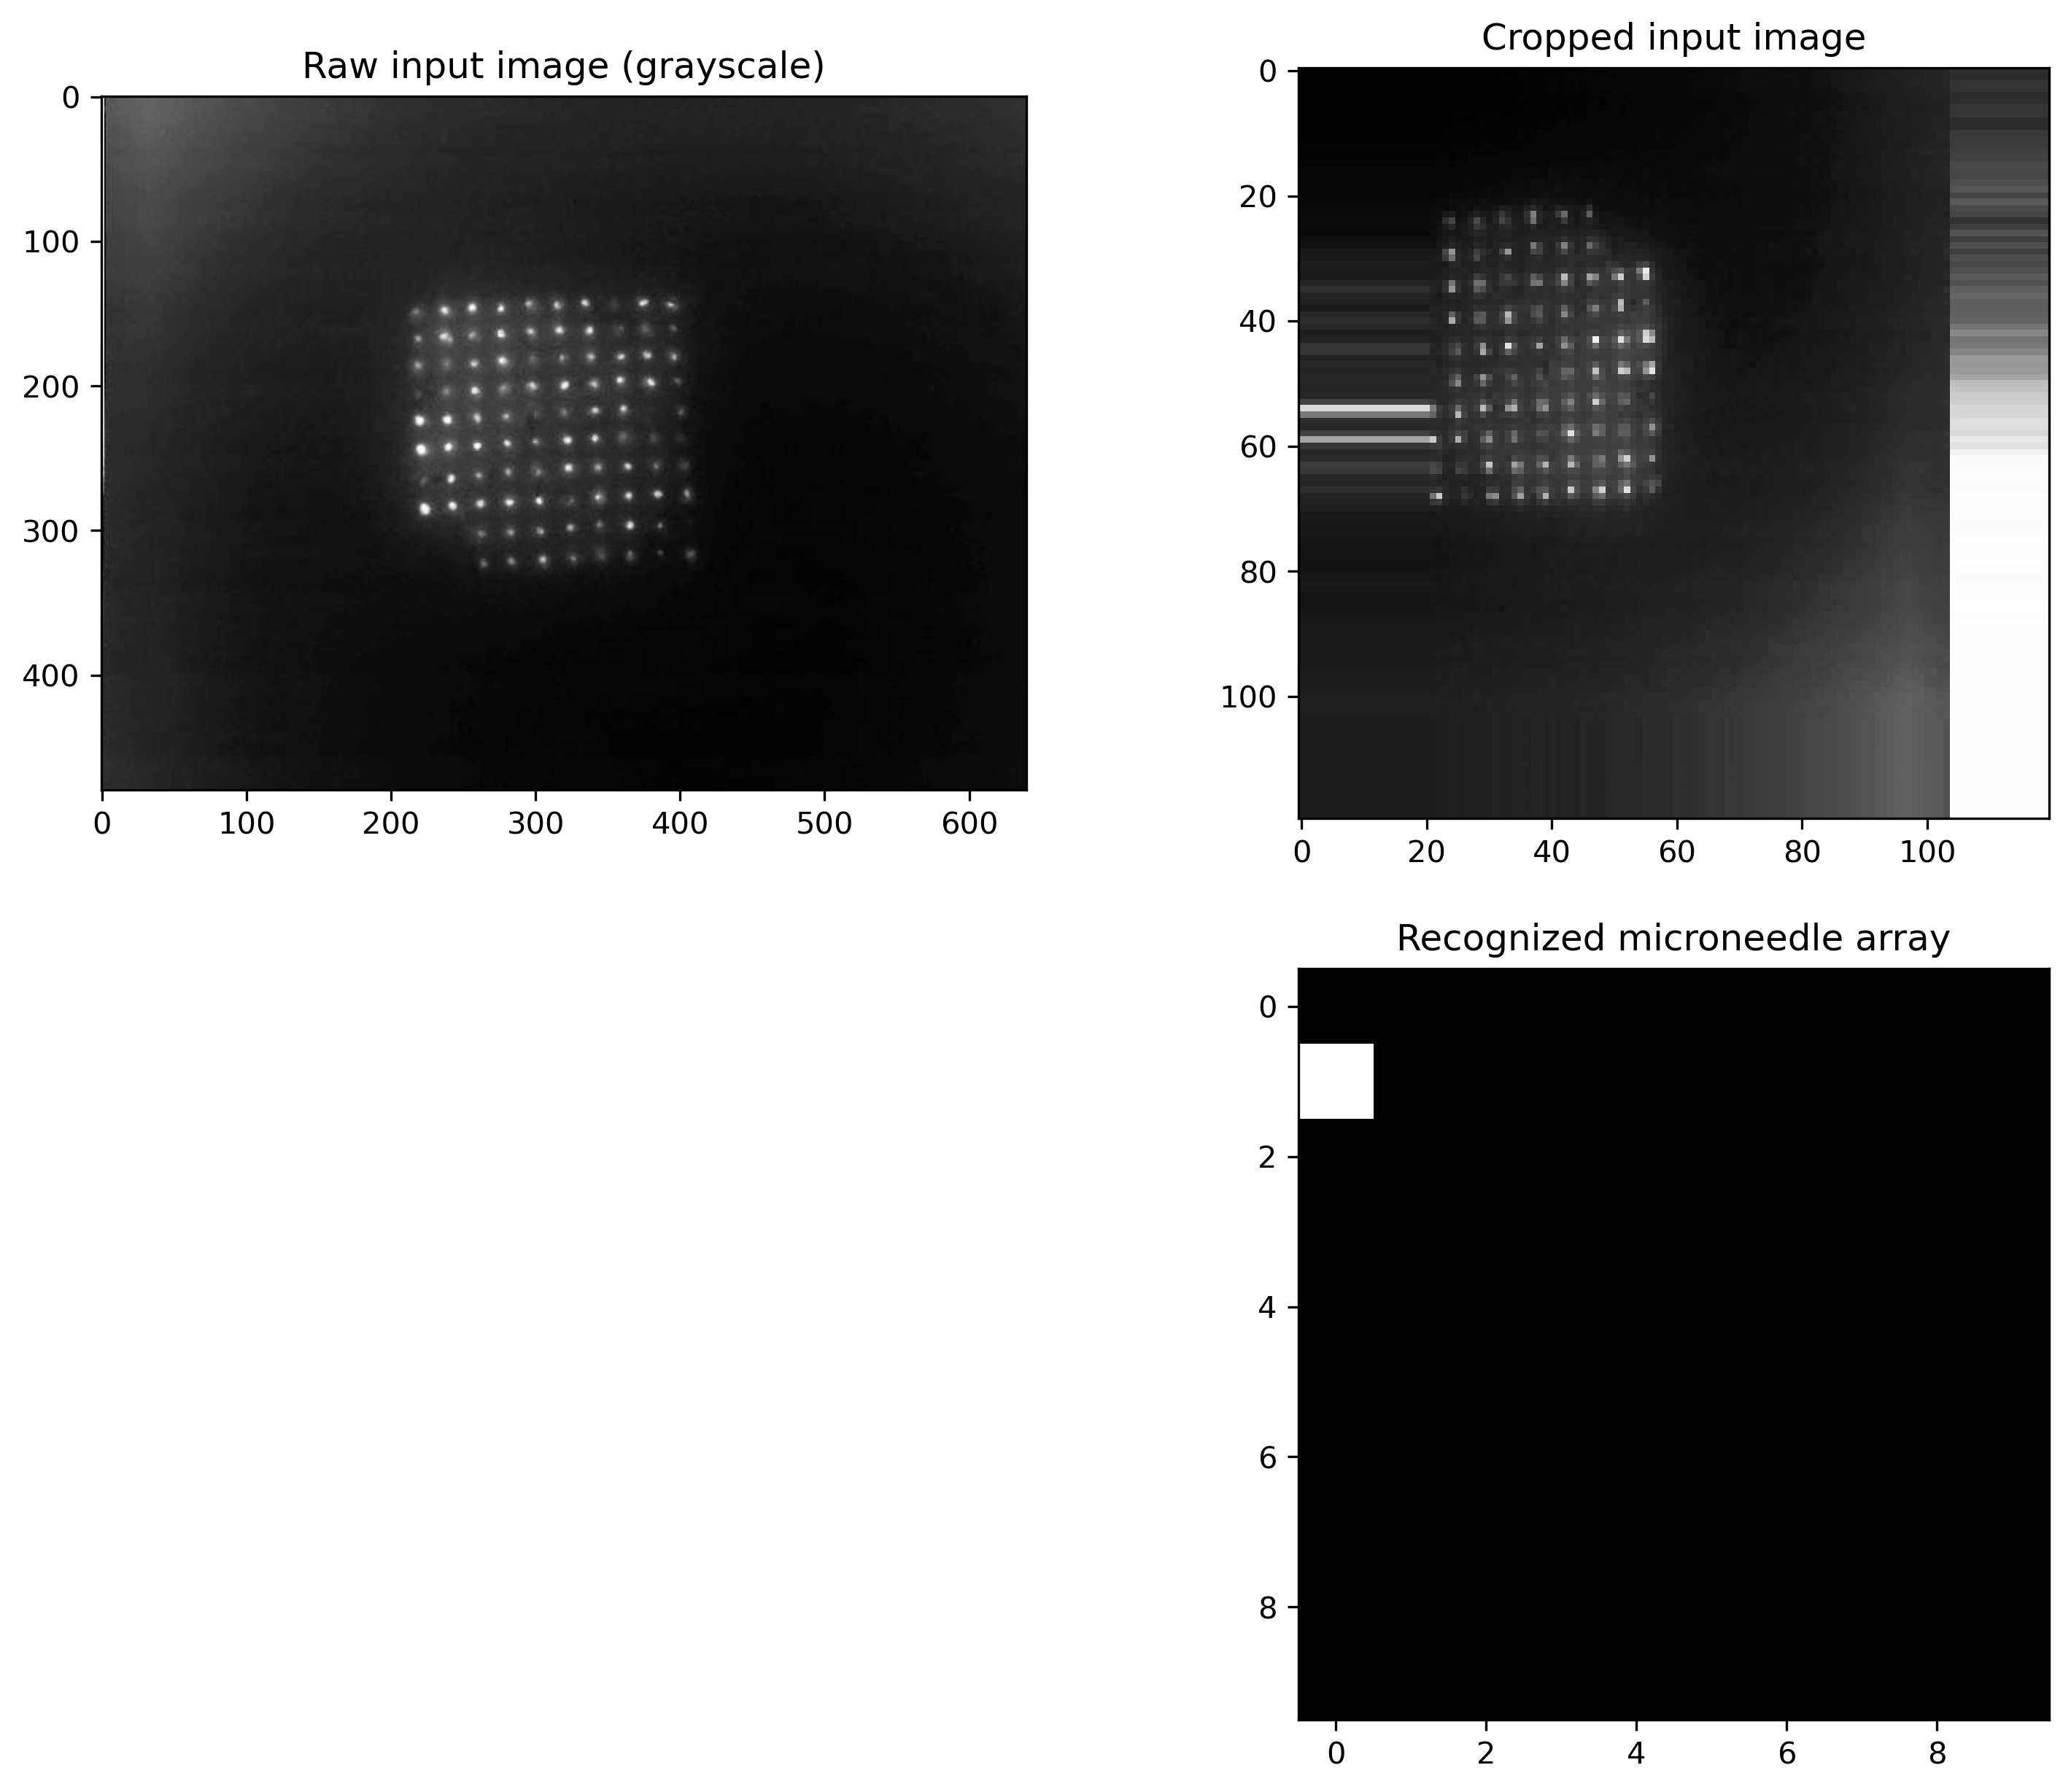

In [4]:
plt.figure(figsize=(12,10),dpi=300)
plt.subplot(221)
plt.imshow(im, cmap='gray')
plt.title('Raw input image (grayscale)')
plt.subplot(222)
plt.imshow(im_crop, cmap='gray')
plt.title('Cropped input image')
plt.subplot(224)
plt.imshow(needle, cmap='gray')
plt.title('Recognized microneedle array')
plt.show()

## Calculating the bit error rate (BER) according to the template
Note that we use the four corners for orientation detection and then get the right orientation of the template and finally include four corners in the bir error rate (BER) as well.

  Number of error pixels: 95
  Bit error rate: 95.00%


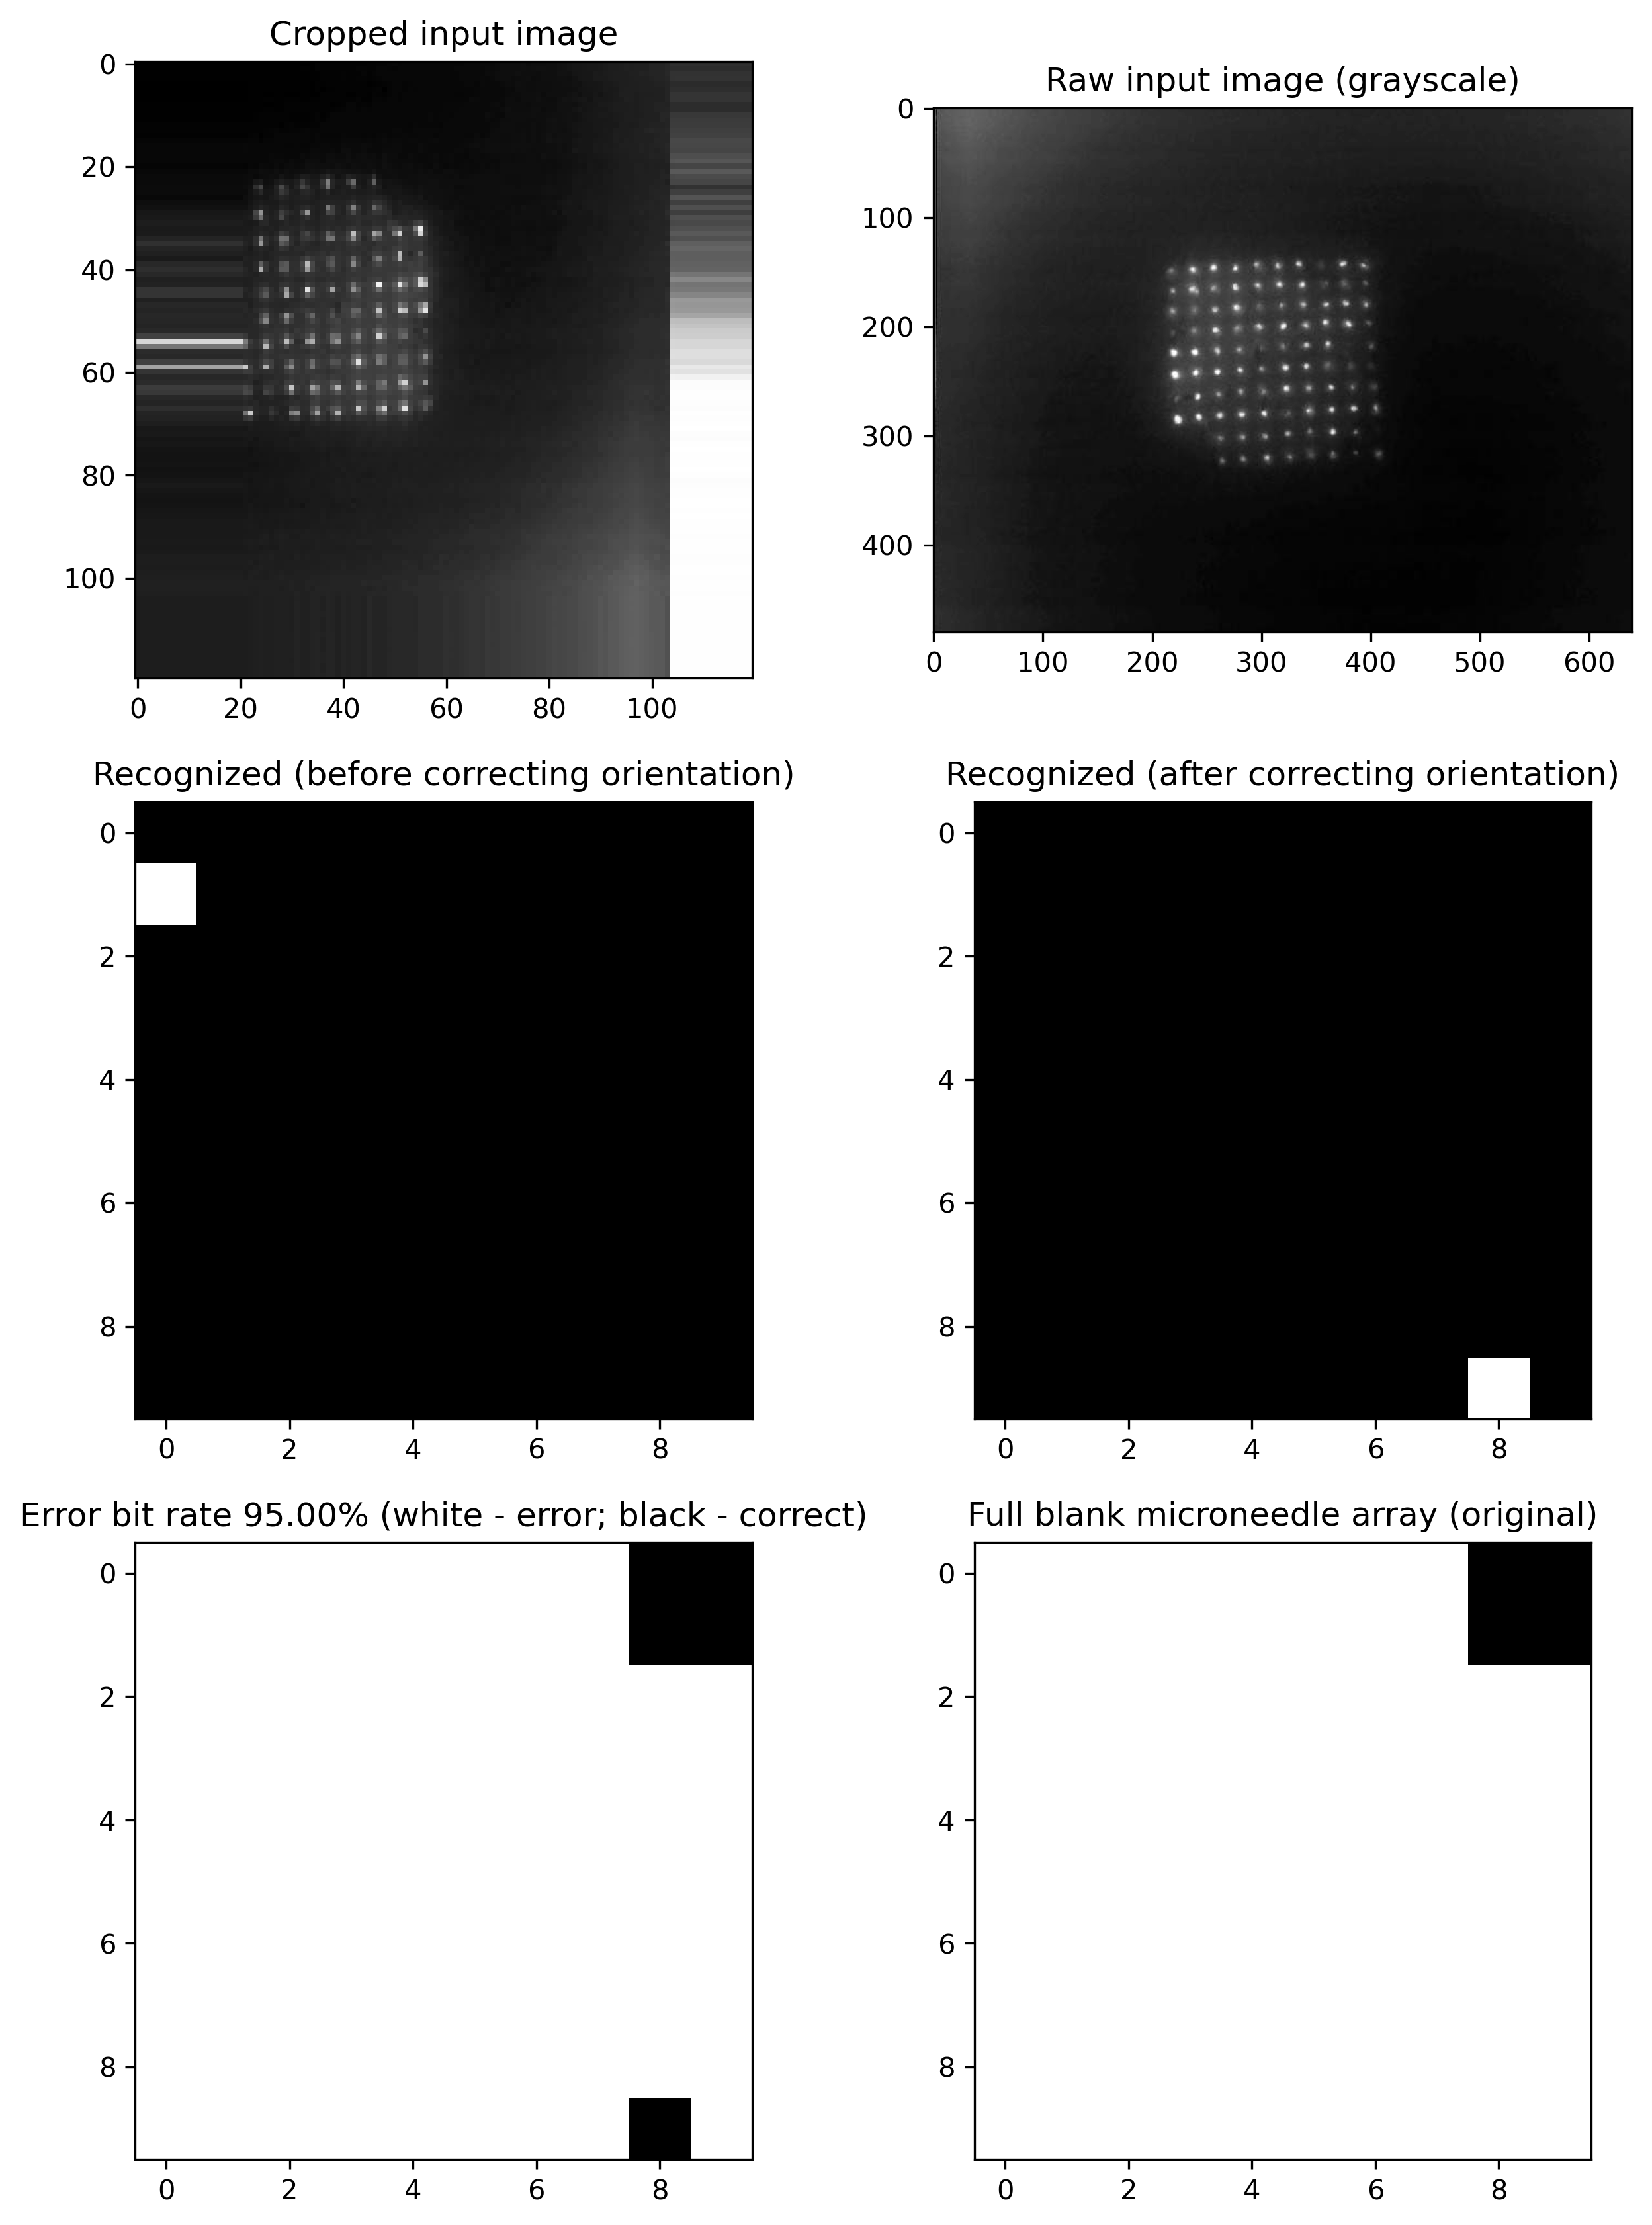

In [5]:
# [0] layout of the microneedle array
#     only use 64 bits for encoding RM(1,8) or [64,7,32]_2-code
s = needle_size   # side of the microneedle array - s x s
p =  2   # preserved 4 corners for orientation (p x p top-right)

# [0.1] show a blank microneedle array with a template
blank = np.ones((s,s), dtype=int) # blank array with all zeros (binary 0/1 )
blank[0:p,0:p] = 1;   # top-left
blank[-p:,0:p] = 1;   # bottom-left
blank[0:p,-p:] = 0;   # top-right
blank[-p:,-p:] = 1;   # bottom-right 

# [1] flip the binary pixel array for deployment
noisyneedle = np.flip(needle, 1).astype(int)

# orientation detection (based on the black corner)
c1 = np.sum(noisyneedle[0:p, 0:p])   # top-left
c2 = np.sum(noisyneedle[0:p, -p:])   # top-right
c3 = np.sum(noisyneedle[-p:, -p:])
c4 = np.sum(noisyneedle[-p:, 0:p])   # bottom-left

rotnum = np.argmin([c1, c2, c3, c4]) + 3

binneedle = np.rot90(noisyneedle, rotnum)

errorneedle = binneedle-blank

num_error_bits = np.count_nonzero(
    errorneedle)  # number of flipped pixel bits

ber = num_error_bits/(s*s)  # bit error rate

print('  Number of error pixels: %d' % num_error_bits)
print('  Bit error rate: {:.2%}'.format(ber))

plt.figure(figsize=(10, 14), dpi=300)
plt.subplot(322)
plt.imshow(im, cmap='gray')
plt.title('Raw input image (grayscale)')
plt.subplot(321)
plt.imshow(im_crop, cmap='gray')
plt.title('Cropped input image')
plt.subplot(323)
plt.imshow(needle, cmap='gray')
plt.title('Recognized (before correcting orientation)')
plt.subplot(324)
plt.imshow(binneedle, cmap='gray')
plt.title('Recognized (after correcting orientation)')
plt.subplot(325)
plt.imshow(np.absolute(errorneedle), cmap='gray')
plt.title(
    'Error bit rate {:.2%} (white - error; black - correct)'.format(ber))
plt.subplot(326)
plt.imshow(blank, cmap='gray')
plt.title('Full blank microneedle array (original)')
plt.show()